# Imports

In [255]:
import string

In [256]:
import numpy as np

In [257]:
import pandas as pd

In [258]:
import matplotlib.pyplot as plt
import seaborn as sns

In [259]:
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer, OneHotEncoder, StandardScaler, MaxAbsScaler, Normalizer, OrdinalEncoder
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer

In [260]:
from scipy.stats import randint, uniform

# Functions

In [261]:
def inspect_df(df : pd.DataFrame):
    print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns')
    print("-" * 30)

    null_values = df.isna().sum()
    if (null_values.sum() == 0):
        print('Null values: 0')
    else:
        print('Null values:')
        print(null_values)
    
    print("-" * 30)
    print('Feature data types:')
    print(df.dtypes)
    print("")

In [262]:
def check_balance(df : pd.DataFrame, target_col : str):
    value_counts = (df[target_col].value_counts(normalize=True) * 100).round(2)
    ideal_share = 100 / len(value_counts)
    
    print(f'Value counts for {target_col}:')
    print(value_counts)
    print("-" * 30)
    print(f'The dataset is balanced if the value counts are close to {ideal_share:.2f}%')

In [263]:
def plot_scatter(df : pd.DataFrame, x_feature : str, y_feature : str):
    plt.scatter(df[x_feature], df[y_feature])
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.show()

In [264]:
def evaluate_classifier(model, x_test, y_test, title : str, f1_average : str='binary'):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average=f1_average)

    print("")
    print(f"{title.title()}:")
    print(f"Accuracy:                   {accuracy:.4f}")
    print(f"F1 score ({f1_average}):        {f1:.4f}")

    disp = ConfusionMatrixDisplay.from_predictions(
        y_pred, y_test,
        cmap=plt.cm.Blues, 
        normalize='true'    # 'true' normalize on rows
    )
    disp.ax_.set_title(title.title())
    plt.show()

In [265]:
def evaluate_regressor(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred = np.abs(y_pred)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    msle = mean_squared_log_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("")
    print(f"MAE:    {mae}")
    print(f"MSE:    {mse}")
    print(f"MSLE:   {msle}")
    print(f"R2:     {r2}")
    print("")
    print("Remember: R2 score is in [-inf, 1]. R2<0 --> BAD MODEL.")

In [266]:
def get_categorical_features(df : pd.DataFrame):
    return df.select_dtypes(include=['object']).columns

In [267]:
def get_k_correlated(df : pd.DataFrame, y_name, k=5):
    y_corr = df.corr()[y_name].abs().sort_values(ascending=False)
    return y_corr[1:(k+1)].index.tolist()

In [268]:
def pfi(model, x_test, y_test):
    pfi = permutation_importance(model, x_test, y_test, n_jobs=-1)
    fig, ax = plt.subplots()
    pd.Series(pfi['importances_mean']).plot.bar(yerr=pfi['importances_std'], ax=ax)
    ax.set_title("Permutation Feature Importance")
    ax.set_ylabel('Importance')
    fig.tight_layout()
    plt.show()

In [269]:
def clean_text(text : str):
    text = text.lower()
    text = text.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split())
    return text

# Exam

In [270]:
df = pd.read_csv('./dataset.csv', sep=',')
df.head()

,Shape,Cut,Color,Clarity,Carat Weight,Length/Width Ratio,Depth %,Table %,Polish,Symmetry,Girdle,Culet,Length,Width,Height,Price,Type,Fluorescence
0,Cushion Modified,Ideal,F,VVS2,1.84,1.02,65.8,59.0,Excellent,Very Good,Medium to Thick,NaN,7.09,6.95,4.57,2640,GIA Lab-Grown,NaN
1,Pear,NaN,E,VS1,1.20,1.65,62.5,58.0,Very Good,Very Good,Medium to Thick,NaN,9.64,5.86,3.66,1070,GIA Lab-Grown,NaN
2,Oval,NaN,E,VS1,1.19,1.41,63.1,63.0,Very Good,Very Good,Medium to Thick,NaN,8.44,6.00,3.79,1070,GIA Lab-Grown,NaN
3,Heart,NaN,D,IF,1.00,1.18,61.7,58.0,Excellent,Excellent,Slightly Thick to Very Thick,NaN,5.85,6.89,4.25,7110,GIA,Faint
4,Radiant,NaN,H,VS1,1.01,1.35,69.4,66.0,Excellent,Very Good,Thick,NaN,6.80,5.05,3.50,3050,GIA,NaN


In [271]:
inspect_df(df)

The dataset has 6485 rows and 18 columns
------------------------------
Null values:
Shape                    5
Cut                   4303
Color                    5
Clarity                  5
Carat Weight             5
Length/Width Ratio       5
Depth %                  7
Table %                 17
Polish                  20
Symmetry                20
Girdle                  22
Culet                 4594
Length                  20
Width                   20
Height                  20
Price                    0
Type                     0
Fluorescence          5264
dtype: int64
------------------------------
Feature data types:
Shape                     str
Cut                       str
Color                     str
Clarity                   str
Carat Weight          float64
Length/Width Ratio    float64
Depth %               float64
Table %               float64
Polish                    str
Symmetry                  str
Girdle                    str
Culet                     str
Lengt

In [272]:
check_balance(df, 'Type')

Value counts for Type:
Type
GIA              51.73
IGI Lab-Grown    28.93
GIA Lab-Grown    19.34
Name: proportion, dtype: float64
------------------------------
The dataset is balanced if the value counts are close to 33.33%


In [273]:
df['Volume'] = (df['Length'] * df['Width'] * df['Height']).round(2)
df.head()

,Shape,Cut,Color,Clarity,Carat Weight,Length/Width Ratio,Depth %,Table %,Polish,Symmetry,Girdle,Culet,Length,Width,Height,Price,Type,Fluorescence,Volume
0,Cushion Modified,Ideal,F,VVS2,1.84,1.02,65.8,59.0,Excellent,Very Good,Medium to Thick,NaN,7.09,6.95,4.57,2640,GIA Lab-Grown,NaN,225.19
1,Pear,NaN,E,VS1,1.20,1.65,62.5,58.0,Very Good,Very Good,Medium to Thick,NaN,9.64,5.86,3.66,1070,GIA Lab-Grown,NaN,206.75
2,Oval,NaN,E,VS1,1.19,1.41,63.1,63.0,Very Good,Very Good,Medium to Thick,NaN,8.44,6.00,3.79,1070,GIA Lab-Grown,NaN,191.93
3,Heart,NaN,D,IF,1.00,1.18,61.7,58.0,Excellent,Excellent,Slightly Thick to Very Thick,NaN,5.85,6.89,4.25,7110,GIA,Faint,171.30
4,Radiant,NaN,H,VS1,1.01,1.35,69.4,66.0,Excellent,Very Good,Thick,NaN,6.80,5.05,3.50,3050,GIA,NaN,120.19


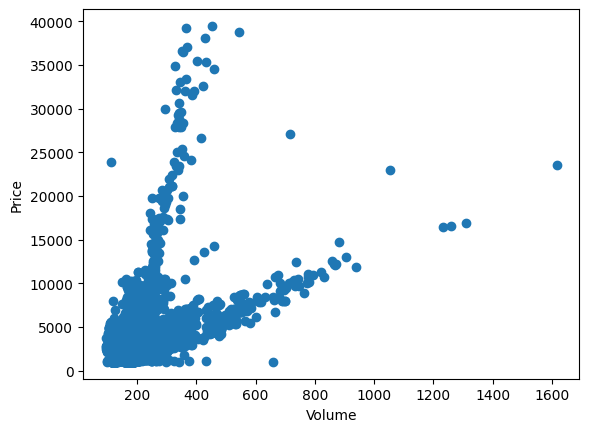

In [274]:
plot_scatter(df, 'Volume', 'Price')

In [275]:
df['Carat Weight'] = df['Carat Weight'].astype('object')
df.loc[df['Cut'].notna(), 'Carat Weight'] = pd.cut(df.loc[df['Cut'].notna(), 'Carat Weight'], bins=5)
df.head()

,Shape,Cut,Color,Clarity,Carat Weight,Length/Width Ratio,Depth %,Table %,Polish,Symmetry,Girdle,Culet,Length,Width,Height,Price,Type,Fluorescence,Volume
0,Cushion Modified,Ideal,F,VVS2,"(1.606, 2.212]",1.02,65.8,59.0,Excellent,Very Good,Medium to Thick,NaN,7.09,6.95,4.57,2640,GIA Lab-Grown,NaN,225.19
1,Pear,NaN,E,VS1,1.2,1.65,62.5,58.0,Very Good,Very Good,Medium to Thick,NaN,9.64,5.86,3.66,1070,GIA Lab-Grown,NaN,206.75
2,Oval,NaN,E,VS1,1.19,1.41,63.1,63.0,Very Good,Very Good,Medium to Thick,NaN,8.44,6.00,3.79,1070,GIA Lab-Grown,NaN,191.93
3,Heart,NaN,D,IF,1.0,1.18,61.7,58.0,Excellent,Excellent,Slightly Thick to Very Thick,NaN,5.85,6.89,4.25,7110,GIA,Faint,171.30
4,Radiant,NaN,H,VS1,1.01,1.35,69.4,66.0,Excellent,Very Good,Thick,NaN,6.80,5.05,3.50,3050,GIA,NaN,120.19


In [276]:
df[df['Cut'].notna()].pivot_table(index=['Cut', 'Carat Weight'], values='Price', aggfunc='mean')

Price
Cut       Carat Weight               
Astor     (0.997, 1.606]  5348.750000
Excellent (0.997, 1.606]  2897.374172
          (1.606, 2.212]  2495.000000
Ideal     (0.997, 1.606]  2299.019417
          (1.606, 2.212]  3803.489933
          (2.212, 2.818]  5288.571429
          (2.818, 3.424]  6523.947368
          (3.424, 4.03]   6917.777778
Very Good (0.997, 1.606]  3379.922481

In [277]:
df = pd.read_csv('./dataset.csv', sep=',')
df.head()

,Shape,Cut,Color,Clarity,Carat Weight,Length/Width Ratio,Depth %,Table %,Polish,Symmetry,Girdle,Culet,Length,Width,Height,Price,Type,Fluorescence
0,Cushion Modified,Ideal,F,VVS2,1.84,1.02,65.8,59.0,Excellent,Very Good,Medium to Thick,NaN,7.09,6.95,4.57,2640,GIA Lab-Grown,NaN
1,Pear,NaN,E,VS1,1.20,1.65,62.5,58.0,Very Good,Very Good,Medium to Thick,NaN,9.64,5.86,3.66,1070,GIA Lab-Grown,NaN
2,Oval,NaN,E,VS1,1.19,1.41,63.1,63.0,Very Good,Very Good,Medium to Thick,NaN,8.44,6.00,3.79,1070,GIA Lab-Grown,NaN
3,Heart,NaN,D,IF,1.00,1.18,61.7,58.0,Excellent,Excellent,Slightly Thick to Very Thick,NaN,5.85,6.89,4.25,7110,GIA,Faint
4,Radiant,NaN,H,VS1,1.01,1.35,69.4,66.0,Excellent,Very Good,Thick,NaN,6.80,5.05,3.50,3050,GIA,NaN


In [278]:
inspect_df(df)

The dataset has 6485 rows and 18 columns
------------------------------
Null values:
Shape                    5
Cut                   4303
Color                    5
Clarity                  5
Carat Weight             5
Length/Width Ratio       5
Depth %                  7
Table %                 17
Polish                  20
Symmetry                20
Girdle                  22
Culet                 4594
Length                  20
Width                   20
Height                  20
Price                    0
Type                     0
Fluorescence          5264
dtype: int64
------------------------------
Feature data types:
Shape                     str
Cut                       str
Color                     str
Clarity                   str
Carat Weight          float64
Length/Width Ratio    float64
Depth %               float64
Table %               float64
Polish                    str
Symmetry                  str
Girdle                    str
Culet                     str
Lengt

In [279]:
df.loc[df['Carat Weight'].notna(), 'PricePerCarat'] = (df.loc[df['Carat Weight'].notna(), 'Price'] / df.loc[df['Carat Weight'].notna(), 'Carat Weight']).round(2)
df.head()

,Shape,Cut,Color,Clarity,Carat Weight,Length/Width Ratio,Depth %,Table %,Polish,Symmetry,Girdle,Culet,Length,Width,Height,Price,Type,Fluorescence,PricePerCarat
0,Cushion Modified,Ideal,F,VVS2,1.84,1.02,65.8,59.0,Excellent,Very Good,Medium to Thick,NaN,7.09,6.95,4.57,2640,GIA Lab-Grown,NaN,1434.78
1,Pear,NaN,E,VS1,1.20,1.65,62.5,58.0,Very Good,Very Good,Medium to Thick,NaN,9.64,5.86,3.66,1070,GIA Lab-Grown,NaN,891.67
2,Oval,NaN,E,VS1,1.19,1.41,63.1,63.0,Very Good,Very Good,Medium to Thick,NaN,8.44,6.00,3.79,1070,GIA Lab-Grown,NaN,899.16
3,Heart,NaN,D,IF,1.00,1.18,61.7,58.0,Excellent,Excellent,Slightly Thick to Very Thick,NaN,5.85,6.89,4.25,7110,GIA,Faint,7110.00
4,Radiant,NaN,H,VS1,1.01,1.35,69.4,66.0,Excellent,Very Good,Thick,NaN,6.80,5.05,3.50,3050,GIA,NaN,3019.80


<Axes: title={'center': 'PricePerCarat'}, xlabel='[Type]'>

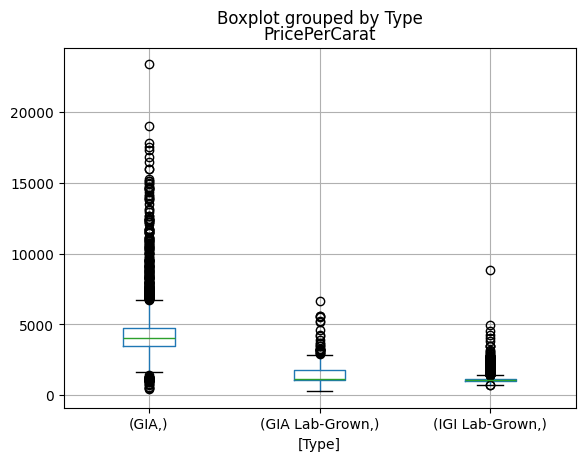

In [280]:
df.boxplot(column=['PricePerCarat'], by=['Type'])

In [281]:
df = pd.read_csv('./dataset.csv', sep=',')
df.head()

,Shape,Cut,Color,Clarity,Carat Weight,Length/Width Ratio,Depth %,Table %,Polish,Symmetry,Girdle,Culet,Length,Width,Height,Price,Type,Fluorescence
0,Cushion Modified,Ideal,F,VVS2,1.84,1.02,65.8,59.0,Excellent,Very Good,Medium to Thick,NaN,7.09,6.95,4.57,2640,GIA Lab-Grown,NaN
1,Pear,NaN,E,VS1,1.20,1.65,62.5,58.0,Very Good,Very Good,Medium to Thick,NaN,9.64,5.86,3.66,1070,GIA Lab-Grown,NaN
2,Oval,NaN,E,VS1,1.19,1.41,63.1,63.0,Very Good,Very Good,Medium to Thick,NaN,8.44,6.00,3.79,1070,GIA Lab-Grown,NaN
3,Heart,NaN,D,IF,1.00,1.18,61.7,58.0,Excellent,Excellent,Slightly Thick to Very Thick,NaN,5.85,6.89,4.25,7110,GIA,Faint
4,Radiant,NaN,H,VS1,1.01,1.35,69.4,66.0,Excellent,Very Good,Thick,NaN,6.80,5.05,3.50,3050,GIA,NaN


In [282]:
inspect_df(df)

The dataset has 6485 rows and 18 columns
------------------------------
Null values:
Shape                    5
Cut                   4303
Color                    5
Clarity                  5
Carat Weight             5
Length/Width Ratio       5
Depth %                  7
Table %                 17
Polish                  20
Symmetry                20
Girdle                  22
Culet                 4594
Length                  20
Width                   20
Height                  20
Price                    0
Type                     0
Fluorescence          5264
dtype: int64
------------------------------
Feature data types:
Shape                     str
Cut                       str
Color                     str
Clarity                   str
Carat Weight          float64
Length/Width Ratio    float64
Depth %               float64
Table %               float64
Polish                    str
Symmetry                  str
Girdle                    str
Culet                     str
Lengt

In [283]:
df = df.drop(columns=['Cut', 'Culet', 'Fluorescence'])

In [284]:
df = df.dropna(how='any')

In [285]:
categorical_features = get_categorical_features(df)
df[categorical_features] = OrdinalEncoder().fit_transform(df[categorical_features])

/tmp/ipykernel_7676/3351726568.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  return df.select_dtypes(include=['object']).columns


In [286]:
inspect_df(df)

The dataset has 6463 rows and 15 columns
------------------------------
Null values: 0
------------------------------
Feature data types:
Shape                 float64
Color                 float64
Clarity               float64
Carat Weight          float64
Length/Width Ratio    float64
Depth %               float64
Table %               float64
Polish                float64
Symmetry              float64
Girdle                float64
Length                float64
Width                 float64
Height                float64
Price                   int64
Type                  float64
dtype: object



In [287]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='Type'), df['Type'], test_size=0.25, stratify=df['Type'])


Decision Tree:
Accuracy:                   0.9189
F1 score (weighted):        0.9191


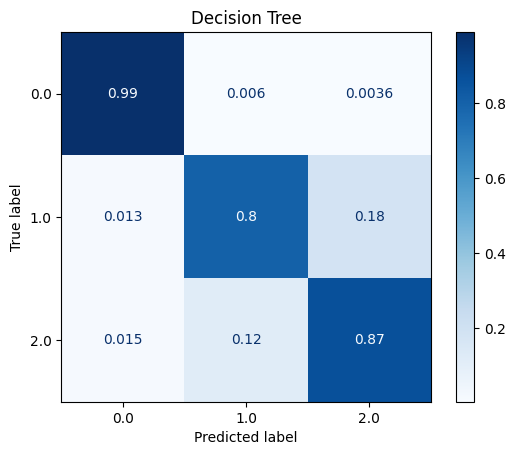


K Neighbors:
Accuracy:                   0.8113
F1 score (weighted):        0.7992


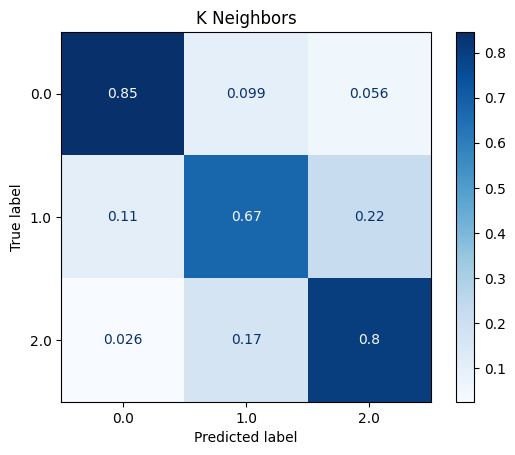


Dummy:
Accuracy:                   0.5179
F1 score (weighted):        0.3535


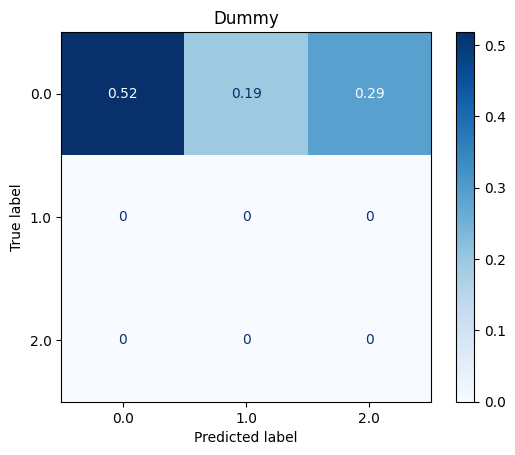

In [288]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
evaluate_classifier(dt, x_test, y_test, 'decision tree', 'weighted')

kn = KNeighborsClassifier()
kn.fit(x_train, y_train)
evaluate_classifier(kn, x_test, y_test, 'k neighbors', 'weighted')

dc = DummyClassifier()
dc.fit(x_train, y_train)
evaluate_classifier(dc, x_test, y_test, 'dummy', 'weighted')

In [289]:
cross_val_score(kn, df.drop(columns='Type'), df['Type'], cv=10, scoring='f1_micro', n_jobs=-1).mean()

np.float64(0.8217526952210965)

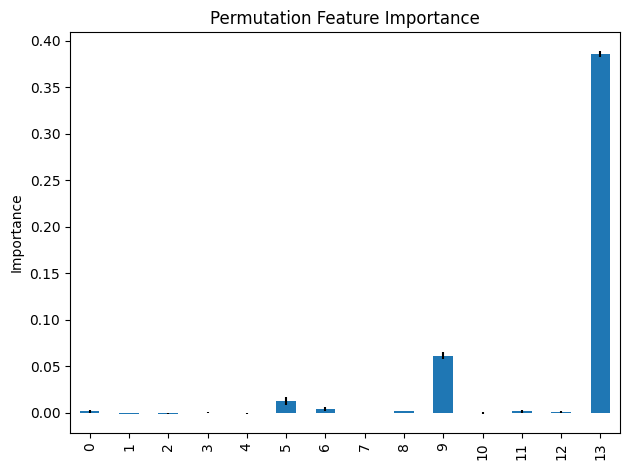

In [290]:
pfi(kn, x_test, y_test)


K Neighbors:
Accuracy:                   0.8082
F1 score (weighted):        0.7988


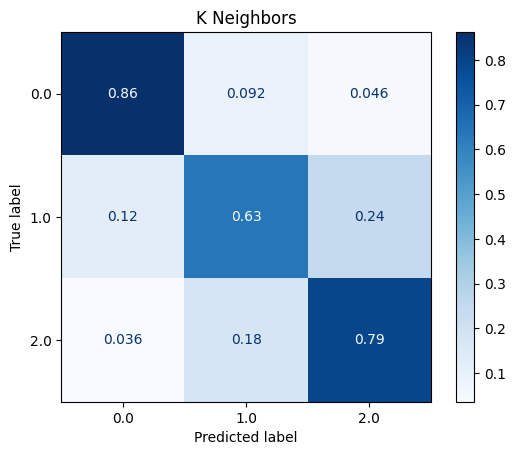

In [291]:
parameters = {
    'weights' : ['uniform', 'distance'],
    'n_neighbors' : [5, 10, 15, 20]
}

gscv = GridSearchCV(KNeighborsClassifier(), param_grid=parameters, cv=10, n_jobs=-1)
gscv.fit(x_train, y_train)
evaluate_classifier(gscv.best_estimator_, x_test, y_test, 'k neighbors', f1_average='weighted')

In [292]:
df.head()

,Shape,Color,Clarity,Carat Weight,Length/Width Ratio,Depth %,Table %,Polish,Symmetry,Girdle,Length,Width,Height,Price,Type
0,1.0,2.0,5.0,1.84,1.02,65.8,59.0,0.0,2.0,7.0,7.09,6.95,4.57,2640,1.0
1,6.0,1.0,2.0,1.20,1.65,62.5,58.0,2.0,2.0,7.0,9.64,5.86,3.66,1070,1.0
2,5.0,1.0,2.0,1.19,1.41,63.1,63.0,2.0,2.0,7.0,8.44,6.00,3.79,1070,1.0
3,3.0,0.0,1.0,1.00,1.18,61.7,58.0,0.0,0.0,13.0,5.85,6.89,4.25,7110,0.0
4,8.0,4.0,2.0,1.01,1.35,69.4,66.0,0.0,2.0,14.0,6.80,5.05,3.50,3050,0.0


In [293]:
col_trans = ColumnTransformer(transformers=[
    ('discretize', KBinsDiscretizer(), ['Length', 'Width', 'Height']),
    ('scale', StandardScaler(), ['Price'])
], remainder='passthrough')

/home/mattia/miniconda3/envs/big-data/lib/python3.14/site-packages/sklearn/preprocessing/_discretization.py:304: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(



Pipeline 1:
Accuracy:                   0.8886
F1 score (weighted):        0.8882


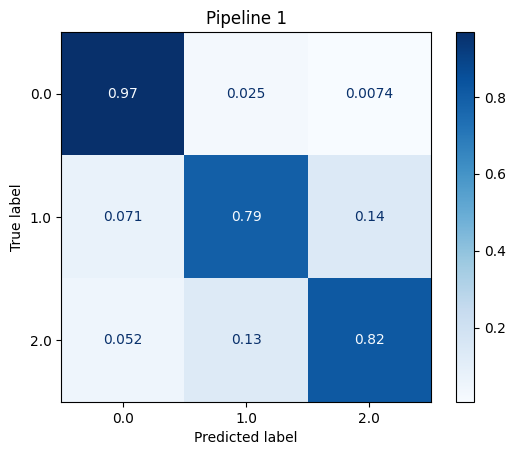

In [294]:
pipeline = Pipeline(steps=[
    ('preprocessor', col_trans),
    ('model', KNeighborsClassifier(n_neighbors=gscv.best_params_['n_neighbors'], weights=gscv.best_params_['weights'], n_jobs=-1))
])

pipeline.fit(x_train, y_train)
evaluate_classifier(pipeline, x_test, y_test, f1_average='weighted', title='pipeline 1')

In [295]:
df = pd.read_csv('./dataset.csv', sep=',')
inspect_df(df)

The dataset has 6485 rows and 18 columns
------------------------------
Null values:
Shape                    5
Cut                   4303
Color                    5
Clarity                  5
Carat Weight             5
Length/Width Ratio       5
Depth %                  7
Table %                 17
Polish                  20
Symmetry                20
Girdle                  22
Culet                 4594
Length                  20
Width                   20
Height                  20
Price                    0
Type                     0
Fluorescence          5264
dtype: int64
------------------------------
Feature data types:
Shape                     str
Cut                       str
Color                     str
Clarity                   str
Carat Weight          float64
Length/Width Ratio    float64
Depth %               float64
Table %               float64
Polish                    str
Symmetry                  str
Girdle                    str
Culet                     str
Lengt

In [296]:
df = df.drop(columns=['Cut', 'Culet', 'Fluorescence'])
inspect_df(df)

The dataset has 6485 rows and 15 columns
------------------------------
Null values:
Shape                  5
Color                  5
Clarity                5
Carat Weight           5
Length/Width Ratio     5
Depth %                7
Table %               17
Polish                20
Symmetry              20
Girdle                22
Length                20
Width                 20
Height                20
Price                  0
Type                   0
dtype: int64
------------------------------
Feature data types:
Shape                     str
Color                     str
Clarity                   str
Carat Weight          float64
Length/Width Ratio    float64
Depth %               float64
Table %               float64
Polish                    str
Symmetry                  str
Girdle                    str
Length                float64
Width                 float64
Height                float64
Price                   int64
Type                      str
dtype: object



In [297]:
df.head()

,Shape,Color,Clarity,Carat Weight,Length/Width Ratio,Depth %,Table %,Polish,Symmetry,Girdle,Length,Width,Height,Price,Type
0,Cushion Modified,F,VVS2,1.84,1.02,65.8,59.0,Excellent,Very Good,Medium to Thick,7.09,6.95,4.57,2640,GIA Lab-Grown
1,Pear,E,VS1,1.20,1.65,62.5,58.0,Very Good,Very Good,Medium to Thick,9.64,5.86,3.66,1070,GIA Lab-Grown
2,Oval,E,VS1,1.19,1.41,63.1,63.0,Very Good,Very Good,Medium to Thick,8.44,6.00,3.79,1070,GIA Lab-Grown
3,Heart,D,IF,1.00,1.18,61.7,58.0,Excellent,Excellent,Slightly Thick to Very Thick,5.85,6.89,4.25,7110,GIA
4,Radiant,H,VS1,1.01,1.35,69.4,66.0,Excellent,Very Good,Thick,6.80,5.05,3.50,3050,GIA


In [298]:
df.columns

Index(['Shape', 'Color', 'Clarity', 'Carat Weight', 'Length/Width Ratio',
       'Depth %', 'Table %', 'Polish', 'Symmetry', 'Girdle', 'Length', 'Width',
       'Height', 'Price', 'Type'],
      dtype='str')

In [ ]:
text_cols = get_categorical_features(df)

col_trans = ColumnTransformer(transformers=[
    ('remove_na', SimpleImputer(strategy='most_frequent'), df.columns),
    ('text_to_class', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), text_cols),
    ('scale', StandardScaler(), df.columns)
], remainder='passthrough')

/tmp/ipykernel_7676/3351726568.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  return df.select_dtypes(include=['object']).columns


In [300]:
pipeline = Pipeline(steps=[
    ('preprocessor', col_trans),
    ('model', KNeighborsClassifier())
])

x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='Type'), df['Type'], test_size=0.25, stratify=df['Type'])
pipeline.fit(x_train, y_train)
evaluate_classifier(pipeline, x_test, y_test, 'pipeline 2', f1_average='weighted')

ValueError: A given column is not a column of the dataframe